In [4]:
from osgeo import gdal
import osgeo

print(osgeo.__version__)

3.4.3


图像大小：(18988, 19796)波段数：1
dataoutput/N51_30_2020LC030/n51_30_2020lc030.tif


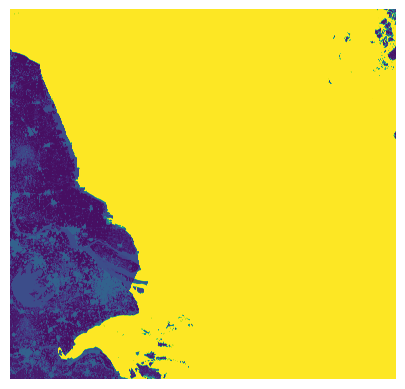

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# 输入图像
def read_tif(path):
    dataset = gdal.Open(path)
    print(dataset.GetDescription())#数据描述

    cols = dataset.RasterXSize#图像长度
    rows = dataset.RasterYSize#图像宽度
    
    im_proj = dataset.GetProjection()#读取投影
    im_Geotrans = dataset.GetGeoTransform()#读取仿射变换
    im_data = dataset.ReadAsArray(0, 0, cols, rows)#转为numpy格式
    
    del dataset
    return im_proj, im_Geotrans,im_data


path=r'dataoutput/N51_30_2020LC030/n51_30_2020lc030.tif'
dataset = gdal.Open(path)

columns = dataset.RasterXSize#图像长度
rows = dataset.RasterYSize#图像宽度
bans=dataset.RasterCount#波段数

print(f"图像大小：{rows, columns}"+f"波段数：{bans}")
im_proj,im_Geotrans,im_data = read_tif(path)#读取tif文件及其投影，行列号，仿射等

# 显示图像
plt.imshow(im_data)
plt.axis('off')
plt.show()

In [14]:
# -*- coding: utf-8 -*-
import os
import numpy
from osgeo import gdal

# 写文件，以写成tif为例
def write_img(self, filename, im_proj, origin_x, origin_y, pixel_width, pixel_height, im_data):
        # gdal数据类型包括
        # gdal.GDT_Byte,
        # gdal .GDT_UInt16, gdal.GDT_Int16, gdal.GDT_UInt32, gdal.GDT_Int32,
        # gdal.GDT_Float32, gdal.GDT_Float64

        # 判断栅格数据的数据类型
        if 'int8' in im_data.dtype.name:
            datatype = gdal.GDT_Byte
        elif 'int16' in im_data.dtype.name:
            datatype = gdal.GDT_UInt16
        else:
            datatype = gdal.GDT_Float32

        # 判读数组维数
        if len(im_data.shape) == 3:
            im_bands, im_height, im_width = im_data.shape
        else:
            im_bands, (im_height, im_width) = 1, im_data.shape

            # 创建文件
        driver = gdal.GetDriverByName("GTiff")  # 数据类型必须有，因为要计算需要多大内存空间
        dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)

        dataset.SetGeoTransform((origin_x, pixel_width, 0, origin_y, 0, pixel_height))  # 写入仿射变换参数
        dataset.SetProjection(im_proj)  # 写入投影

        if im_bands == 1:
            dataset.GetRasterBand(1).WriteArray(im_data)  # 写入数组数据
        else:
            for i in range(im_bands):
                dataset.GetRasterBand(i + 1).WriteArray(im_data[i])

        del dataset


# 计算某行列下像元经纬度
def calcLonLat(dataset, x, y):
    minx, xres, xskew, maxy, yskew, yres = dataset.GetGeoTransform()
    lon = minx + xres * x
    lat = maxy +xres * y
    return lon, lat

# os.chdir(r'E:/data')  # 切换路径到待处理图像所在文件夹
# file_name = r"E:\pythonWS\readgeotiff\python_server_data\tiff\200002_result.tif"
# dataset = gdal.Open(file_name)
minx, xres, xskew, maxy, yskew, yres = dataset.GetGeoTransform()

print(im_proj)
print(im_Geotrans)
print(im_data)

# columns, rows = dataset.shape

size=1024

for j in range(columns // size):  # 切割成256*256小图
    for i in range(rows // size):
        if(j==columns//size):
                cur_image = dataset[i * size:(i + 1) * size, j * size:(j + 1) * size]
                lon = minx + xres * size * j
                lat = maxy + yres * (i * size)
                write_img(r'dataoutput/Tiff_cut/{}_{}.tif'.format(i, j), im_proj,
                                 lon, lat, xres, yres, cur_image,im_data)  ##写数据
        else:
                cur_image = dataset[i*size:(i + 1) * size, j * size:(j + 1) * size]
                lon=minx+xres*size*j
                lat=maxy+yres*(i*size)
                write_img(r'dataoutput/Tiff_cut/{}_{}.tif'.format(i, j), im_proj,
                                 lon, lat, xres, yres, cur_image,dataset,im_data)  ##写数据


PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]
(203065.592041406, 30.0, 0.0, 3884685.741600337, 0.0, -30.0)
[[255 255 255 ...  20  20   0]
 [255 255 255 ...  20  20   0]
 [255 255 255 ...  20  80   0]
 ...
 [ 80  80  80 ... 255 255   0]
 [ 80  80  80 ... 255 255   0]
 [ 80  80  80 ... 255 255   0]]


TypeError: 'Dataset' object is not subscriptable

In [6]:
#输出图像
def write_tif(newpath,im_data,im_Geotrans,im_proj,datatype):
    if len(im_data.shape)==3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    diver = gdal.GetDriverByName('GTiff')
    new_dataset = diver.Create(newpath, im_width, im_height, im_bands, datatype)
    new_dataset.SetGeoTransform(im_Geotrans)
    new_dataset.SetProjection(im_proj)

    if im_bands == 1:
        new_dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            new_dataset.GetRasterBand(i+1).WriteArray(im_data[i])
    del new_dataset

newpath="haojiaohuo.tif"#输出位置
# write_tif(newpath,im_data,im_Geotrans,im_proj,gdal.GDT_UInt16)
write_tif(newpath,im_data,im_Geotrans,im_proj,gdal.GDT_Int16)


In [2]:
dir(dataset)

['AbortSQL',
 'AddBand',
 'AddFieldDomain',
 'AdviseRead',
 'BeginAsyncReader',
 'BuildOverviews',
 'ClearStatistics',
 'CommitTransaction',
 'CopyLayer',
 'CreateLayer',
 'CreateMaskBand',
 'DeleteLayer',
 'EndAsyncReader',
 'ExecuteSQL',
 'FlushCache',
 'GetDescription',
 'GetDriver',
 'GetFieldDomain',
 'GetFileList',
 'GetGCPCount',
 'GetGCPProjection',
 'GetGCPSpatialRef',
 'GetGCPs',
 'GetGeoTransform',
 'GetLayer',
 'GetLayerByIndex',
 'GetLayerByName',
 'GetLayerCount',
 'GetMetadata',
 'GetMetadataDomainList',
 'GetMetadataItem',
 'GetMetadata_Dict',
 'GetMetadata_List',
 'GetNextFeature',
 'GetProjection',
 'GetProjectionRef',
 'GetRasterBand',
 'GetRootGroup',
 'GetSpatialRef',
 'GetStyleTable',
 'GetSubDatasets',
 'GetTiledVirtualMem',
 'GetTiledVirtualMemArray',
 'GetVirtualMem',
 'GetVirtualMemArray',
 'IsLayerPrivate',
 'RasterCount',
 'RasterXSize',
 'RasterYSize',
 'ReadAsArray',
 'ReadRaster',
 'ReadRaster1',
 'ReleaseResultSet',
 'ResetReading',
 'RollbackTransaction